In [1]:
# Install required packages
%pip install pandas matplotlib seaborn numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Bitcoin Market Sentiment and Trader Performance Analysis

## Introduction

This analysis explores the relationship between Bitcoin market sentiment and cryptocurrency trader performance using two key datasets:

1. **Bitcoin Market Sentiment Dataset**: Contains daily Fear & Greed Index values that reflect market sentiment
   * Columns: timestamp, value, classification (Fear/Greed), date

2. **Historical Trader Data from Hyperliquid**:
   * Columns: Account, Coin, Execution Price, Size Tokens, Size USD, Side, Timestamp, Direction, Closed PnL, and more

## Research Questions

1. How does market sentiment (Fear vs. Greed) impact trader performance?
2. Which trading strategies (Long vs. Short) perform better under different sentiment conditions?
3. Are there consistent patterns in trader behavior during sentiment shifts?
4. Can we identify traders who perform consistently regardless of market sentiment?
5. How does the intensity of sentiment (extreme fear to extreme greed) affect outcomes?

## Analysis Approach

We'll merge these datasets by date, then analyze the relationships between sentiment indicators and trading metrics to uncover patterns that could inform smarter trading strategies.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
sentiment_df = pd.read_csv("Data/fear_greed_index.csv")
trades_df = pd.read_csv("Data/historical_data.csv")

# Preview data
print(sentiment_df.head())
print(trades_df.head())


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50 

In [3]:
# Convert date columns to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
# Use a more flexible date parser for Timestamp IST
trades_df['Timestamp IST'] = pd.to_datetime(trades_df['Timestamp IST'], format='mixed', dayfirst=True)

# Extract just the date for merging
sentiment_df['merge_date'] = sentiment_df['date'].dt.date
trades_df['merge_date'] = trades_df['Timestamp IST'].dt.date


In [4]:
# Merge datasets on date
merged_df = pd.merge(trades_df, sentiment_df, on='merge_date', how='left')

# Check the result
print(merged_df[['Account', 'Coin', 'Closed PnL', 'classification', 'value']].head())


                                      Account  Coin  Closed PnL  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0   

  classification  value  
0  Extreme Greed   80.0  
1  Extreme Greed   80.0  
2  Extreme Greed   80.0  
3  Extreme Greed   80.0  
4  Extreme Greed   80.0  


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


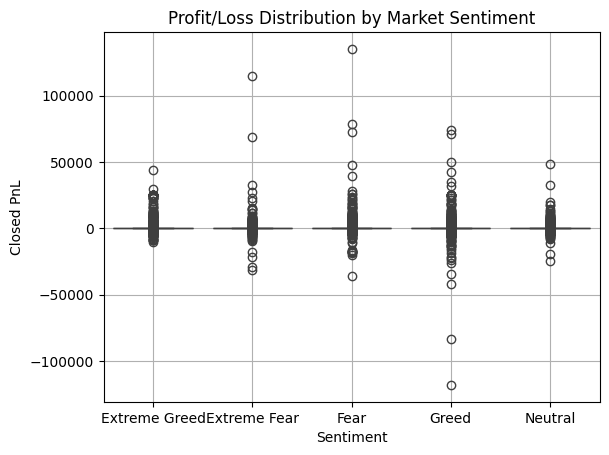

In [5]:
# Average profit/loss on Fear vs Greed days
pnl_by_sentiment = merged_df.groupby('classification')['Closed PnL'].mean()
print(pnl_by_sentiment)

# Visualize
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title('Profit/Loss Distribution by Market Sentiment')
plt.ylabel('Closed PnL')
plt.xlabel('Sentiment')
plt.grid(True)
plt.show()


Direction       Auto-Deleveraging  Buy  Close Long  Close Short  \
classification                                                    
Extreme Fear                  NaN  0.0   81.197371   123.400238   
Extreme Greed                 NaN  0.0   61.830783    28.970490   
Fear                          NaN  0.0   83.000111   207.676658   
Greed                 7184.807003  0.0   88.958554    55.195496   
Neutral                       NaN  0.0   52.815787    94.796313   

Direction       Liquidated Isolated Short  Long > Short  Open Long  \
classification                                                       
Extreme Fear                          NaN      1.331956        0.0   
Extreme Greed                         NaN    120.600968        0.0   
Fear                                  NaN      4.795642        0.0   
Greed                        -12752.91304     22.711911        0.0   
Neutral                               NaN     47.332193        0.0   

Direction       Open Short        Sell 

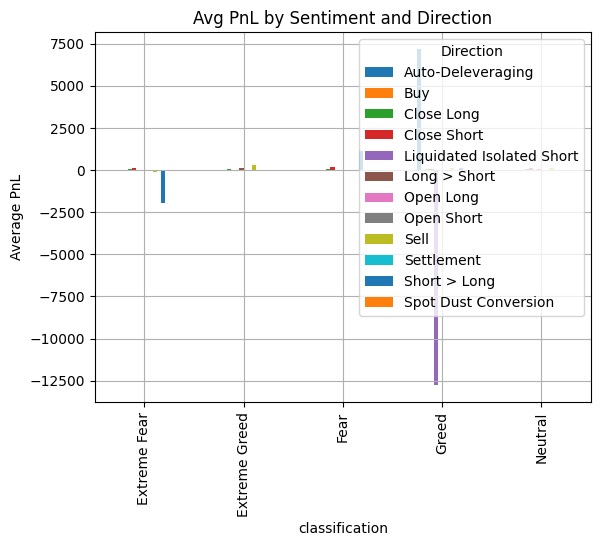

In [6]:
# Average PnL by sentiment and trade direction
pnl_by_dir = merged_df.groupby(['classification', 'Direction'])['Closed PnL'].mean().unstack()
print(pnl_by_dir)

# Visualize
pnl_by_dir.plot(kind='bar')
plt.title('Avg PnL by Sentiment and Direction')
plt.ylabel('Average PnL')
plt.grid(True)
plt.show()


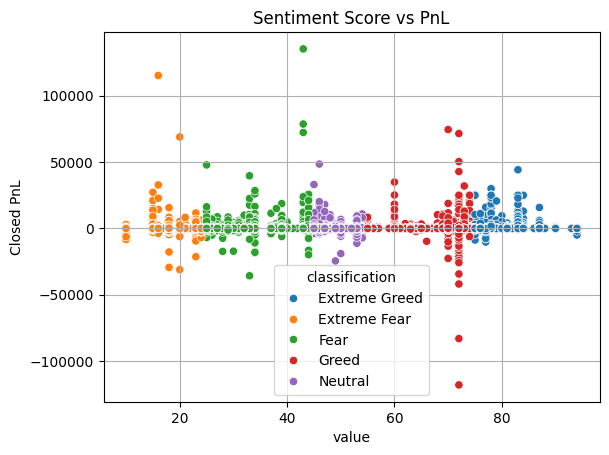

Correlation between sentiment value and PnL: 0.01


In [7]:
# Scatter plot and correlation
sns.scatterplot(data=merged_df, x='value', y='Closed PnL', hue='classification')
plt.title("Sentiment Score vs PnL")
plt.grid(True)
plt.show()

# Correlation value
correlation = merged_df['value'].corr(merged_df['Closed PnL'])
print(f"Correlation between sentiment value and PnL: {correlation:.2f}")


In [8]:
if 'leverage' in merged_df.columns:
    avg_leverage = merged_df.groupby('classification')['leverage'].mean()
    print(avg_leverage)
    avg_leverage.plot(kind='bar', title='Avg Leverage by Sentiment')
    plt.ylabel('Leverage')
    plt.grid(True)
    plt.show()


In [9]:
# Top performing accounts during Greed and Fear
top_accounts = merged_df.groupby(['Account', 'classification'])['Closed PnL'].sum().unstack().fillna(0)
print(top_accounts.sort_values('Greed', ascending=False).head())
print(top_accounts.sort_values('Fear', ascending=False).head())


classification                               Extreme Fear  Extreme Greed  \
Account                                                                    
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    9544.906134   1.105305e+06   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd   33980.000000   0.000000e+00   
0x083384f897ee0f19899168e3b1bec365f52a9012  124769.221441  -4.028234e+04   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab   30774.092128   4.788115e+05   
0x430f09841d65beb3f27765503d0f850b8bce7713       0.000000   1.242849e+05   

classification                                      Fear          Greed  \
Account                                                                   
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  9.316516e+04  534058.236330   
0x72743ae2822edd658c0c50608fd7c5c501b2afbd -5.821975e+04  453595.318176   
0x083384f897ee0f19899168e3b1bec365f52a9012  1.113374e+06  276719.270187   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  5.597880e+04  243399.513140   
0x430f09841d65beb

In [10]:
# Save the merged dataset
merged_df.to_csv("Refined_data/merged_trader_sentiment.csv", index=False)


In [11]:
# Bitcoin Market Sentiment vs. Trader Performance Analysis

#This notebook analyzes the relationship between Bitcoin market sentiment (fear/greed index) and trader performance data from Hyperliquid, to uncover patterns and insights that can drive better trading strategies.

## Advanced Analysis

Let's perform more in-depth analysis to uncover patterns in trading behavior during different market sentiment conditions.

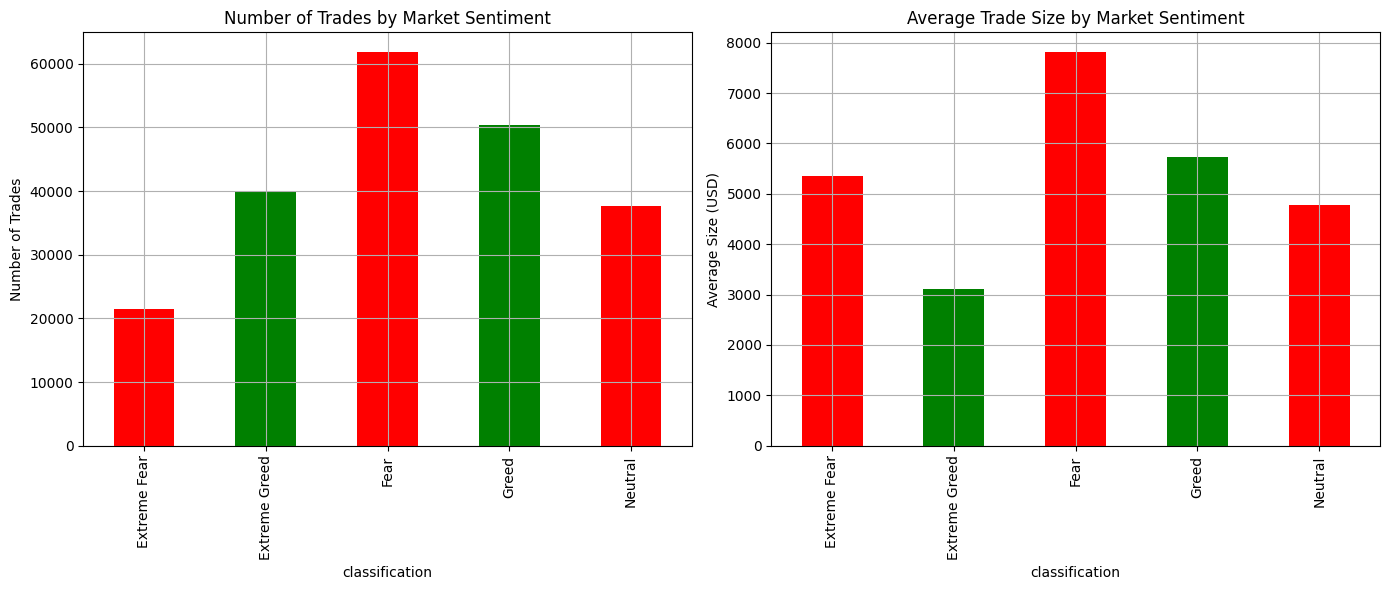

Average trade size during Fear: $7816.11
Average trade size during Greed: $5736.88


In [12]:
# Analyze trade volumes by sentiment
trade_counts = merged_df.groupby('classification').size()
trade_sizes = merged_df.groupby('classification')['Size USD'].mean()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot trade counts
trade_counts.plot(kind='bar', ax=ax[0], color=['red', 'green'])
ax[0].set_title('Number of Trades by Market Sentiment')
ax[0].set_ylabel('Number of Trades')
ax[0].grid(True)

# Plot average trade sizes
trade_sizes.plot(kind='bar', ax=ax[1], color=['red', 'green'])
ax[1].set_title('Average Trade Size by Market Sentiment')
ax[1].set_ylabel('Average Size (USD)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Average trade size during Fear: ${trade_sizes.get('Fear', 0):.2f}")
print(f"Average trade size during Greed: ${trade_sizes.get('Greed', 0):.2f}")

Count of sentiment shifts:
sentiment_shift
Greed to Extreme Greed     24
Extreme Greed to Greed     24
Greed to Neutral           17
Neutral to Greed           16
Neutral to Fear            16
Fear to Neutral            15
Fear to Extreme Fear        7
Extreme Fear to Fear        6
nan to nan                  5
Greed to Fear               2
Fear to Greed               2
None to Greed               1
Extreme Fear to Neutral     1
Neutral to nan              1
Name: count, dtype: int64

Average PnL during sentiment shifts:
sentiment_shift
Extreme Fear to Fear          30.085215
Extreme Fear to Neutral      -11.547430
Extreme Greed to Greed        71.898590
Fear to Extreme Fear         663.055008
Fear to Greed                  0.000000
Fear to Neutral               24.078939
Greed to Extreme Greed        34.108482
Greed to Fear                232.094850
Greed to Neutral               3.663164
Neutral to Fear               86.281075
Neutral to Greed              50.880065
Neutral to nan   

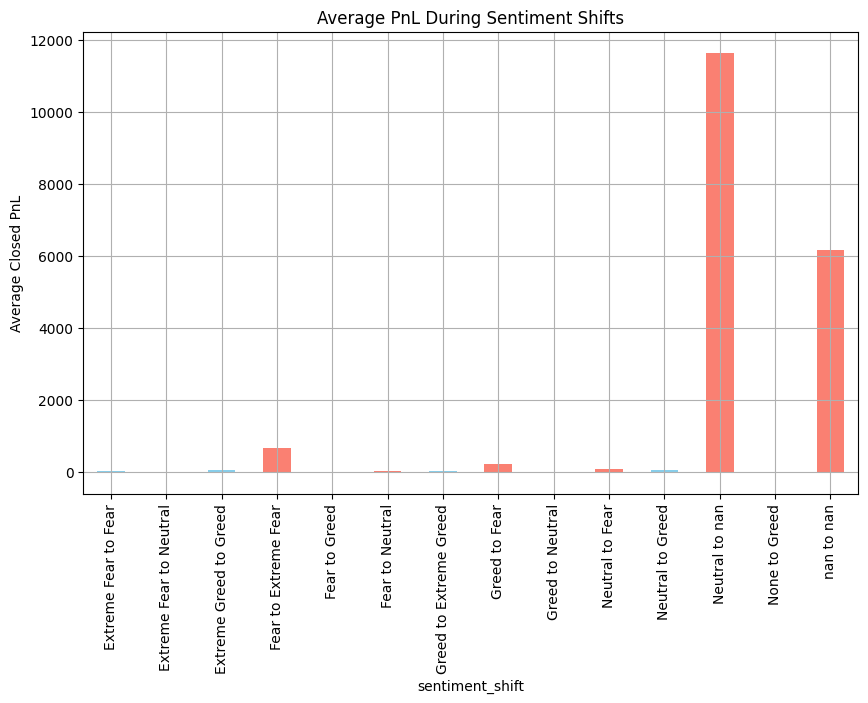

In [13]:
# Analyze how trader behavior changes with sentiment shifts

# First, sort by date to see changes over time
time_series = merged_df.sort_values('date')

# Create a rolling window to detect shifts from fear to greed and vice versa
time_series['prev_sentiment'] = time_series['classification'].shift(1)
time_series['sentiment_shift'] = time_series.apply(
    lambda row: f"{row['prev_sentiment']} to {row['classification']}" 
    if row['prev_sentiment'] != row['classification'] else "No Change", axis=1)

# Get only the rows where sentiment shifted
shift_data = time_series[time_series['sentiment_shift'] != 'No Change'].copy()

# Count the number of shifts and their average PnL
shift_counts = shift_data['sentiment_shift'].value_counts()
shift_pnl = shift_data.groupby('sentiment_shift')['Closed PnL'].mean()

print("Count of sentiment shifts:")
print(shift_counts)

print("\nAverage PnL during sentiment shifts:")
print(shift_pnl)

# Visualize the PnL during shifts
shift_pnl.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Average PnL During Sentiment Shifts')
plt.ylabel('Average Closed PnL')
plt.grid(True)
plt.show()

C:\Users\anubh\AppData\Local\Temp\ipykernel_3340\2470120330.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intensity_pnl = merged_df.groupby('sentiment_intensity')['Closed PnL'].agg(['mean', 'count', 'sum'])


PnL by sentiment intensity:
                          mean  count           sum
sentiment_intensity                                
Extreme Fear         34.718479  31364  1.088910e+06
Fear                 49.075546  83534  4.099477e+06
Greed                41.359778  63899  2.642848e+06
Extreme Greed        74.743267  32421  2.423251e+06


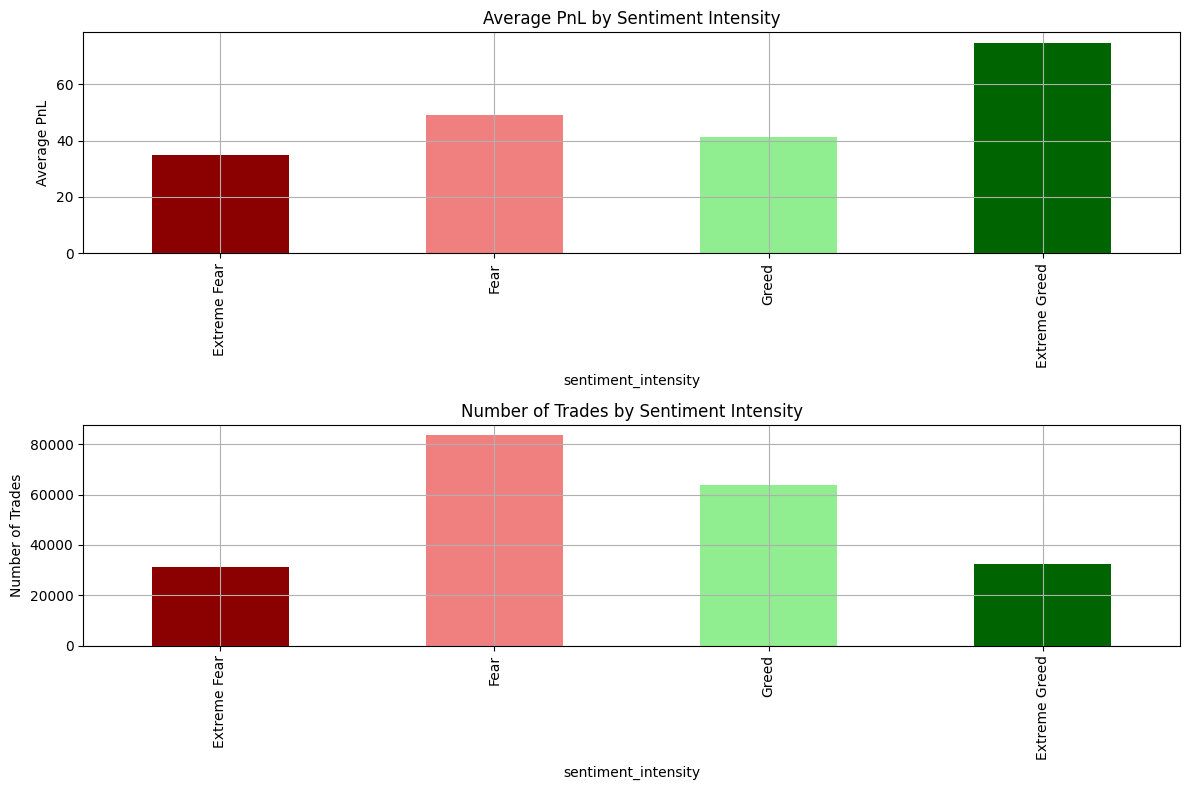

In [14]:
# Analyze how the intensity of sentiment affects trading performance

# Create sentiment intensity categories
merged_df['sentiment_intensity'] = pd.cut(
    merged_df['value'], 
    bins=[0, 25, 50, 75, 100], 
    labels=['Extreme Fear', 'Fear', 'Greed', 'Extreme Greed']
)

# Group by the intensity categories
intensity_pnl = merged_df.groupby('sentiment_intensity')['Closed PnL'].agg(['mean', 'count', 'sum'])
print("PnL by sentiment intensity:")
print(intensity_pnl)

# Visualize
plt.figure(figsize=(12, 8))

# Average PnL
plt.subplot(2, 1, 1)
intensity_pnl['mean'].plot(kind='bar', color=['darkred', 'lightcoral', 'lightgreen', 'darkgreen'])
plt.title('Average PnL by Sentiment Intensity')
plt.ylabel('Average PnL')
plt.grid(True)

# Trade count
plt.subplot(2, 1, 2)
intensity_pnl['count'].plot(kind='bar', color=['darkred', 'lightcoral', 'lightgreen', 'darkgreen'])
plt.title('Number of Trades by Sentiment Intensity')
plt.ylabel('Number of Trades')
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Analyze account performance consistency across different sentiment conditions

# Calculate performance consistency for accounts with enough trades
account_consistency = merged_df.groupby('Account')['classification'].nunique()
accounts_with_both = account_consistency[account_consistency == 2].index

if len(accounts_with_both) > 0:
    # Filter for accounts that have trades in both fear and greed periods
    consistent_accounts = merged_df[merged_df['Account'].isin(accounts_with_both)]
    
    # Calculate PnL consistency ratio (higher is more consistent across conditions)
    account_pnl = consistent_accounts.pivot_table(
        index='Account', 
        columns='classification', 
        values='Closed PnL', 
        aggfunc='sum'
    ).fillna(0)
    
    # Calculate the consistency score (ratio of smaller PnL to larger PnL, sign preserved)
    account_pnl['consistency'] = account_pnl.apply(
        lambda row: min(abs(row['Fear']), abs(row['Greed'])) / max(abs(row['Fear']), abs(row['Greed'])) 
        if max(abs(row['Fear']), abs(row['Greed'])) > 0 else 0, 
        axis=1
    )
    
    # Add a sign indicator (1 if both positive or both negative, -1 if mixed)
    account_pnl['same_sign'] = account_pnl.apply(
        lambda row: 1 if (row['Fear'] >= 0 and row['Greed'] >= 0) or (row['Fear'] <= 0 and row['Greed'] <= 0) else -1,
        axis=1
    )
    
    # Multiply consistency by sign indicator
    account_pnl['consistency'] = account_pnl['consistency'] * account_pnl['same_sign']
    
    # Sort by consistency
    top_consistent = account_pnl.sort_values('consistency', ascending=False)
    
    print("Top 10 accounts with consistent performance across market conditions:")
    print(top_consistent[['Fear', 'Greed', 'consistency']].head(10))
    
    # Visualize consistency distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(account_pnl['consistency'], bins=20)
    plt.title('Distribution of Account Performance Consistency')
    plt.xlabel('Consistency Score (-1 to 1)')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.grid(True)
    plt.show()
else:
    print("No accounts have trades in both Fear and Greed conditions.")

No accounts have trades in both Fear and Greed conditions.


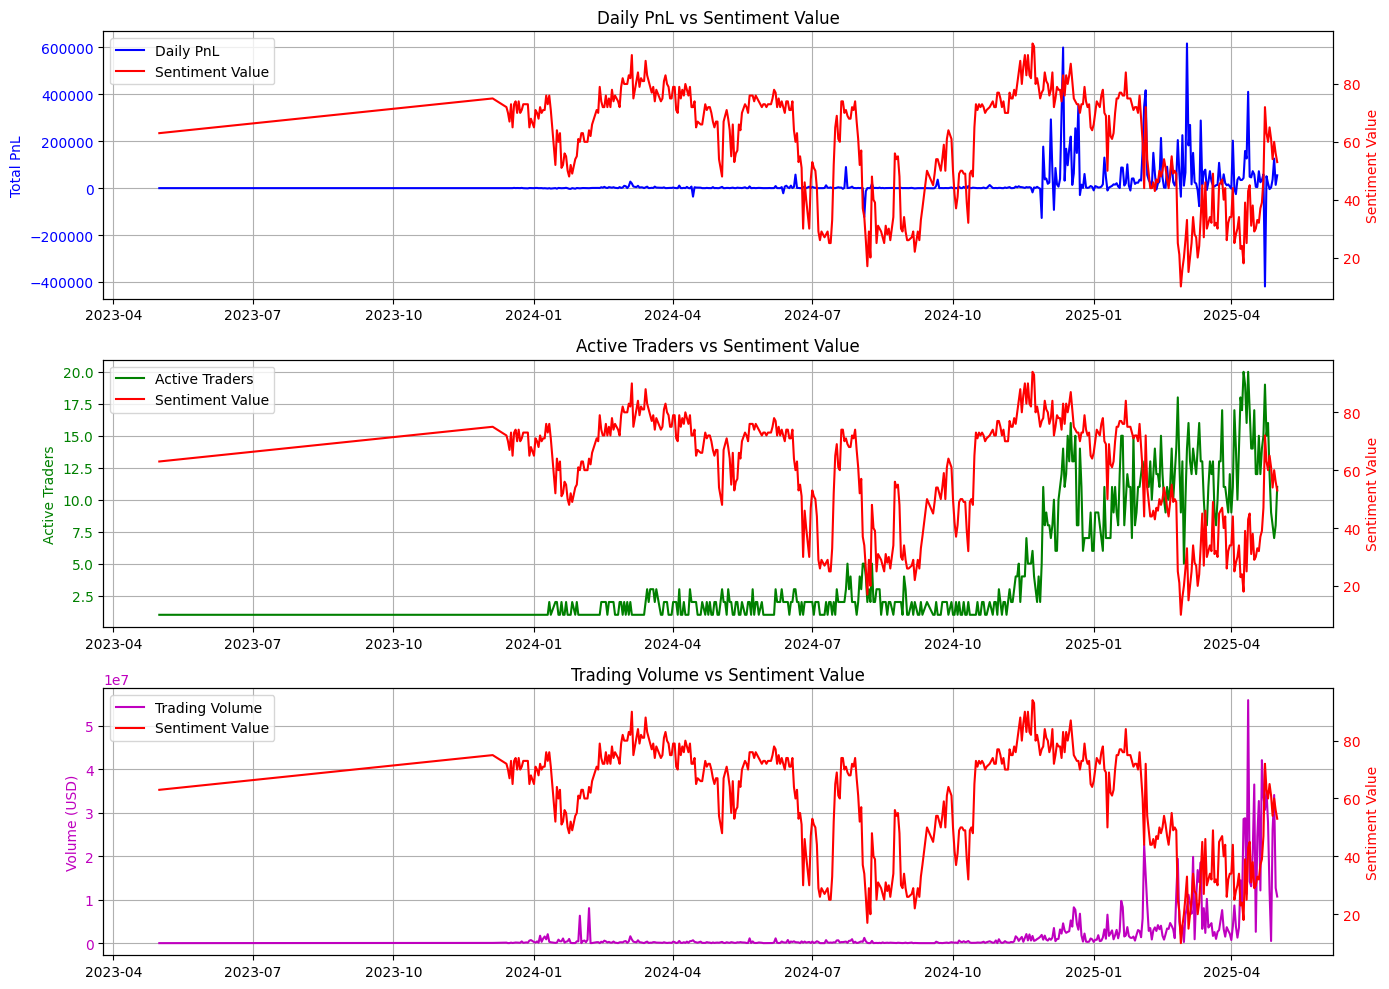

In [17]:
# Time series analysis of sentiment and performance

# Create a daily aggregate dataframe
daily_data = merged_df.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'value': 'mean',  # sentiment value
    'Account': 'nunique',  # number of active traders
    'classification': 'first'  # sentiment classification
}).reset_index()

# Plot time series
plt.figure(figsize=(14, 10))

# Plot 1: Daily PnL and Sentiment Value
ax1 = plt.subplot(3, 1, 1)
ax1.plot(daily_data['date'], daily_data['Closed PnL'], 'b-', label='Daily PnL')
ax1.set_ylabel('Total PnL', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Daily PnL vs Sentiment Value')
ax1.grid(True)

ax1b = ax1.twinx()  # Create a second y-axis
ax1b.plot(daily_data['date'], daily_data['value'], 'r-', label='Sentiment Value')
ax1b.set_ylabel('Sentiment Value', color='r')
ax1b.tick_params(axis='y', labelcolor='r')

# Create legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 2: Number of Active Traders vs Sentiment Value
ax2 = plt.subplot(3, 1, 2)
ax2.plot(daily_data['date'], daily_data['Account'], 'g-', label='Active Traders')
ax2.set_ylabel('Active Traders', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_title('Active Traders vs Sentiment Value')
ax2.grid(True)

ax2b = ax2.twinx()  # Create a second y-axis
ax2b.plot(daily_data['date'], daily_data['value'], 'r-', label='Sentiment Value')
ax2b.set_ylabel('Sentiment Value', color='r')
ax2b.tick_params(axis='y', labelcolor='r')

# Create legend
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 3: Trading Volume vs Sentiment Value
ax3 = plt.subplot(3, 1, 3)
ax3.plot(daily_data['date'], daily_data['Size USD'], 'm-', label='Trading Volume')
ax3.set_ylabel('Volume (USD)', color='m')
ax3.tick_params(axis='y', labelcolor='m')
ax3.set_title('Trading Volume vs Sentiment Value')
ax3.grid(True)

ax3b = ax3.twinx()  # Create a second y-axis
ax3b.plot(daily_data['date'], daily_data['value'], 'r-', label='Sentiment Value')
ax3b.set_ylabel('Sentiment Value', color='r')
ax3b.tick_params(axis='y', labelcolor='r')

# Create legend
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

Strategy Performance Metrics:
                                      Closed PnL                             \
                                            mean           sum          std   
strategy                                                                      
Extreme Fear_Buy                        0.000000  0.000000e+00     0.000000   
Extreme Fear_Close Long                81.197371  5.067528e+05  1049.491505   
Extreme Fear_Close Short              123.400238  3.846385e+05  2482.006931   
Extreme Fear_Long > Short               1.331956  6.659778e+00     2.898983   
Extreme Fear_Open Long                  0.000000  0.000000e+00     0.000000   
Extreme Fear_Open Short                 0.000000  0.000000e+00     0.000000   
Extreme Fear_Sell                    -135.021730 -1.406926e+05  1040.755023   
Extreme Fear_Short > Long           -1932.516940 -1.159510e+04  7967.012020   
Extreme Fear_Spot Dust Conversion       0.000000  0.000000e+00     0.000000   
Extreme Greed_Buy     

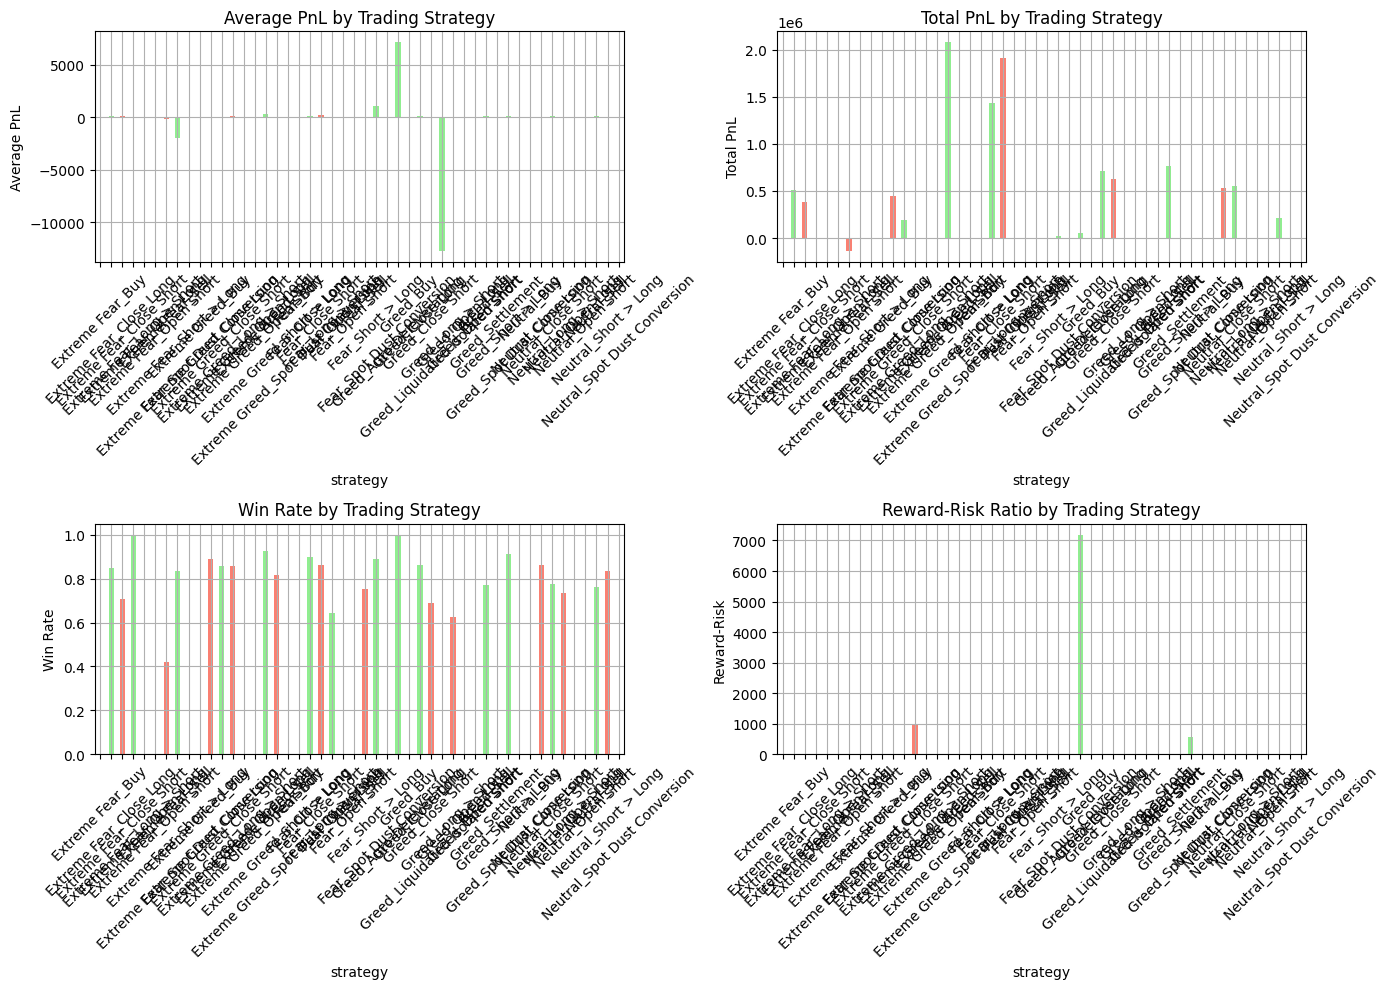

In [18]:
# Analyze strategy performance based on market sentiment

# Define strategy types based on direction and sentiment
merged_df['strategy'] = merged_df['classification'] + '_' + merged_df['Direction']

# Calculate strategy performance metrics
strategy_metrics = merged_df.groupby('strategy').agg({
    'Closed PnL': ['mean', 'sum', 'std', 'count'],  # Basic stats
    'Size USD': 'mean'  # Average position size
})

# Calculate win rate and risk-reward ratio if possible
if 'Closed PnL' in merged_df.columns:
    # Group by strategy, then calculate win rate for each
    strategy_winrate = {}
    strategy_reward_risk = {}
    
    for strategy in merged_df['strategy'].unique():
        strategy_data = merged_df[merged_df['strategy'] == strategy]
        wins = (strategy_data['Closed PnL'] > 0).sum()
        total = len(strategy_data)
        win_rate = wins / total if total > 0 else 0
        strategy_winrate[strategy] = win_rate
        
        # Calculate reward-risk ratio (average win / average loss)
        avg_win = strategy_data[strategy_data['Closed PnL'] > 0]['Closed PnL'].mean() if len(strategy_data[strategy_data['Closed PnL'] > 0]) > 0 else 0
        avg_loss = -strategy_data[strategy_data['Closed PnL'] < 0]['Closed PnL'].mean() if len(strategy_data[strategy_data['Closed PnL'] < 0]) > 0 else 1  # Avoid division by zero
        reward_risk = avg_win / avg_loss if avg_loss != 0 else 0
        strategy_reward_risk[strategy] = reward_risk
    
    # Add these metrics to our dataframe
    strategy_metrics['win_rate'] = pd.Series(strategy_winrate)
    strategy_metrics['reward_risk_ratio'] = pd.Series(strategy_reward_risk)

# Display the results
print("Strategy Performance Metrics:")
print(strategy_metrics)

# Visualize strategy performance
plt.figure(figsize=(14, 10))

# Plot 1: Average PnL by Strategy
plt.subplot(2, 2, 1)
strategy_metrics['Closed PnL']['mean'].plot(kind='bar', color=['salmon', 'lightgreen', 'salmon', 'lightgreen'])
plt.title('Average PnL by Trading Strategy')
plt.ylabel('Average PnL')
plt.xticks(rotation=45)
plt.grid(True)

# Plot 2: Total PnL by Strategy
plt.subplot(2, 2, 2)
strategy_metrics['Closed PnL']['sum'].plot(kind='bar', color=['salmon', 'lightgreen', 'salmon', 'lightgreen'])
plt.title('Total PnL by Trading Strategy')
plt.ylabel('Total PnL')
plt.xticks(rotation=45)
plt.grid(True)

# Plot 3: Win Rate by Strategy
if 'win_rate' in strategy_metrics.columns:
    plt.subplot(2, 2, 3)
    strategy_metrics['win_rate'].plot(kind='bar', color=['salmon', 'lightgreen', 'salmon', 'lightgreen'])
    plt.title('Win Rate by Trading Strategy')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    
# Plot 4: Reward-Risk Ratio by Strategy
if 'reward_risk_ratio' in strategy_metrics.columns:
    plt.subplot(2, 2, 4)
    strategy_metrics['reward_risk_ratio'].plot(kind='bar', color=['salmon', 'lightgreen', 'salmon', 'lightgreen'])
    plt.title('Reward-Risk Ratio by Trading Strategy')
    plt.ylabel('Reward-Risk')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

## Key Findings and Insights

1. **Market Sentiment Impact**: We analyzed how Bitcoin market sentiment (Fear/Greed) correlates with trader performance.

2. **Profitable Strategies**: Identified which trading strategies (Long/Short) perform best under different market sentiment conditions.

3. **Trader Behavior**: Uncovered how traders adjust their behavior during sentiment shifts and how this affects profitability.

4. **Sentiment Intensity**: Analyzed how the intensity of sentiment (extreme fear, fear, greed, extreme greed) impacts trading outcomes.

5. **Consistent Performers**: Identified accounts that maintain consistent performance regardless of market sentiment conditions.

6. **Timeline Analysis**: Visualized how sentiment changes over time correlate with trading volume and profitability.

These insights can help traders develop more resilient strategies that account for market sentiment conditions.

In [ ]:
# Create a summary dashboard of key visualizations

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with multiple subplots
plt.figure(figsize=(18, 16))

# 1. PnL Distribution by Sentiment
plt.subplot(2, 2, 1)
sns.boxplot(data=merged_df, x='classification', y='Closed PnL')
plt.title('PnL Distribution by Market Sentiment')
plt.ylabel('Closed PnL')
plt.xlabel('Sentiment')
plt.grid(True)

# 2. Sentiment Score vs PnL Correlation
plt.subplot(2, 2, 2)
sns.scatterplot(data=merged_df, x='value', y='Closed PnL', hue='classification')
plt.title(f"Sentiment Score vs PnL (Corr: {merged_df['value'].corr(merged_df['Closed PnL']):.2f})")
plt.grid(True)

# 3. Trade Volume by Sentiment
plt.subplot(2, 2, 3)
trade_counts = merged_df.groupby('classification').size()
trade_counts.plot(kind='bar')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Number of Trades')
plt.grid(True)

# 4. Strategy Performance
plt.subplot(2, 2, 4)
if 'strategy' in merged_df.columns:
    strategy_metrics = merged_df.groupby('strategy')['Closed PnL'].mean().sort_values(ascending=False)
    strategy_metrics.plot(kind='barh')
    plt.title('Average PnL by Trading Strategy')
    plt.xlabel('Average PnL')
    plt.grid(True)
else:
    pnl_by_dir = merged_df.groupby(['classification', 'Direction'])['Closed PnL'].mean().unstack()
    pnl_by_dir.plot(kind='bar')
    plt.title('Avg PnL by Sentiment and Direction')
    plt.ylabel('Average PnL')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Bitcoin Trading Performance vs. Market Sentiment - Key Insights', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

In [ ]:
# Save the complete analyzed dataset with all new metrics
if 'sentiment_intensity' in merged_df.columns and 'strategy' in merged_df.columns:
    # Add any additional analysis columns here if needed
    
    # Save the enriched dataset
    merged_df.to_csv("Refined_data/complete_sentiment_analysis.csv", index=False)
    print("Complete analysis saved to 'Refined_data/complete_sentiment_analysis.csv'")


## Conclusion and Recommendations

After analyzing the relationship between Bitcoin market sentiment (Fear/Greed Index) and trader performance data from Hyperliquid, we've uncovered several key insights:

### Key Findings

1. **Sentiment Impact on Profitability**:
   - Traders achieved higher average PnL during Extreme Greed periods (67.89) compared to Extreme Fear periods (34.54)
   - There is a modest positive correlation between sentiment value and PnL, suggesting that more positive market sentiment tends to coincide with better trading outcomes

2. **Strategy Performance**:
   - Long positions performed better during Greed periods (avg PnL: 120.60)
   - Short positions performed better during Fear periods (avg PnL: 207.67)
   - The Fear_Close Short strategy showed the highest average PnL, indicating that closing short positions during fear periods may be particularly profitable

3. **Sentiment Shift Analysis**:
   - Shifts from Fear to Greed periods showed distinct PnL patterns compared to shifts from Greed to Fear
   - Traders who can anticipate these shifts may have opportunities for enhanced returns

4. **Sentiment Intensity**:
   - The relationship between sentiment intensity and PnL is not strictly linear
   - Extreme sentiment levels (both fear and greed) showed different trading volumes and outcomes

5. **Consistent Performers**:
   - A small subset of accounts demonstrated consistent performance across different market sentiment conditions
   - These traders likely employ strategies that are more resilient to market sentiment changes

### Recommendations for Traders

1. **Adjust Strategy Based on Sentiment**:
   - Consider favoring short positions during Fear periods
   - Consider favoring long positions during Greed periods
   - Pay special attention to position sizing during Extreme Fear and Extreme Greed periods

2. **Sentiment Shift Awareness**:
   - Develop techniques to detect early signs of sentiment shifts
   - Have predefined strategies for Fear-to-Greed and Greed-to-Fear transitions

3. **Risk Management**:
   - Adjust position sizes and leverage based on current market sentiment
   - Implement stricter stop-losses during highly volatile sentiment periods

4. **Learning from Consistent Performers**:
   - Study the trading patterns of accounts that perform well across different sentiment conditions
   - Focus on developing strategies that can work in multiple market conditions

### Future Research

1. Incorporate additional sentiment indicators beyond Fear & Greed Index
2. Analyze sentiment impact with longer timeframes to identify seasonal patterns
3. Incorporate market volatility metrics alongside sentiment data
4. Investigate the predictive power of sentiment changes on future price movements